In [19]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Generamos 5 predictores (X1 a X5) correlacionados para simular multicolinealidad
N = 100
X_base = np.random.normal(0, 1, N)
X = np.column_stack([
    X_base,
    X_base + np.random.normal(0, 0.3, N),  # X2 muy correlacionado con X1
    X_base + np.random.normal(0, 0.4, N),  # X3
    np.random.normal(0, 1, N),             # X4 independiente
    np.random.normal(0, 1, N)              # X5 independiente
])

# Verdaderos coeficientes
beta_verdaderos = np.array([3.0, 2.5, -1.5, 0.8, 1.2])
intercepto_verdadero = 4.0

# y = intercepto + X @ beta + ruido
sigma_ruido = 3.0
epsilon = np.random.normal(0, sigma_ruido, N)
y = intercepto_verdadero + X @ beta_verdaderos + epsilon

# Matriz de diseño completa: columna de unos + predictores
X_design = np.column_stack((np.ones(N), X))

print("¡Datos generados correctamente!")
print("X_design shape:", X_design.shape)     # Debe ser (100, 6)
print("y shape:", y.shape)                   # Debe ser (100,)
print("Coeficientes verdaderos:", beta_verdaderos)

¡Datos generados correctamente!
X_design shape: (100, 6)
y shape: (100,)
Coeficientes verdaderos: [ 3.   2.5 -1.5  0.8  1.2]


In [20]:
def ridge_regression(X, y, lambda_param=0.0):
    """
    Ridge regression manual.
    lambda_param = 0 → OLS normal
    lambda_param = 0 → ridge
    """
    n, p = X.shape # n observaciones, p parametros (incluyendo intercepto)

    # Matriz identidad para penalizacion (solo sobre los coeficientes, NO intercepto)
    I = np.eye(p)
    I[0, 0] = 0 # No penalizamos el intercepto

    # (X^T X + λI)^-1 X^T y
    XtX_plus_lambdaI = X.T @ X + lambda_param * I
    XtX_inv = np.linalg.inv(XtX_plus_lambdaI)
    betas_ridge = XtX_inv @ X.T @ y

    return betas_ridge

# Prueba con OLS (lambda=0)
betas_ols = ridge_regression(X_design, y, lambda_param=0.0)

print("¡Llegué aquí! betas_ols calculado.")
print("Forma de betas_ols:", betas_ols.shape)  # debería ser (6,)
print("OLS (λ=0):")
print("Intercepto estimado:", betas_ols[0])
print("Coeficientes estimados:", betas_ols[1:])

def soft_threshold(rho, lambda_param):
    """
    Operador de sofr-thresholding para L1
    rho: valor sin penalizacion
    lambda_param: penalizacion
    """

    if rho < -lambda_param:
        return rho + lambda_param
    elif rho > lambda_param:
        return rho - lambda_param
    else:
        return 0.0    


def lasso_coordinate_descent(X, y, lambda_param=1.0, max_iter=1000, tol=1e-4):
    """
    Coordinate Descent para Lasso (sin intercepto penalizado)
    X: (N, p) con la columna de unos
    y: (N,)
    """

    n, p = X.shape
    beta = np.zeros(p)   # Inicializada coeficientes en 0

    # Precomputa normal el cuadrado de cada columna (para eficiencia)
    X_norm_sq = np.sum(X**2, axis=0)

    for interation in range(max_iter):
        beta_old = beta.copy()


        for j in range(p):
            # Computa el residuo sin la contribucion de la variable j
            r = y - X @ beta + X[:, j] * beta[j]

            # Rho: correlacion parcial (Xj^T r / ||Xj||^2)
            rho = X[:, j].T @ r / X_norm_sq[j]

            # Actualizacion beta[j] con soft-threshold
            if j == 0:  # Intercepto: no penalizamos
                beta[j] = rho
            else:
                beta[j] = soft_threshold(rho, lambda_param / X_norm_sq[j])

        # Criterio de convergencia
        if np.max(np.abs(beta_old)) < tol:
            print(f"Convergencia en iternacion {interation+1}")
            break
    return beta


¡Llegué aquí! betas_ols calculado.
Forma de betas_ols: (6,)
OLS (λ=0):
Intercepto estimado: 3.5994694710577697
Coeficientes estimados: [ 4.72952851  1.2206816  -2.39952294  1.01785448  0.90378739]


Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1
Convergencia en iternacion 1


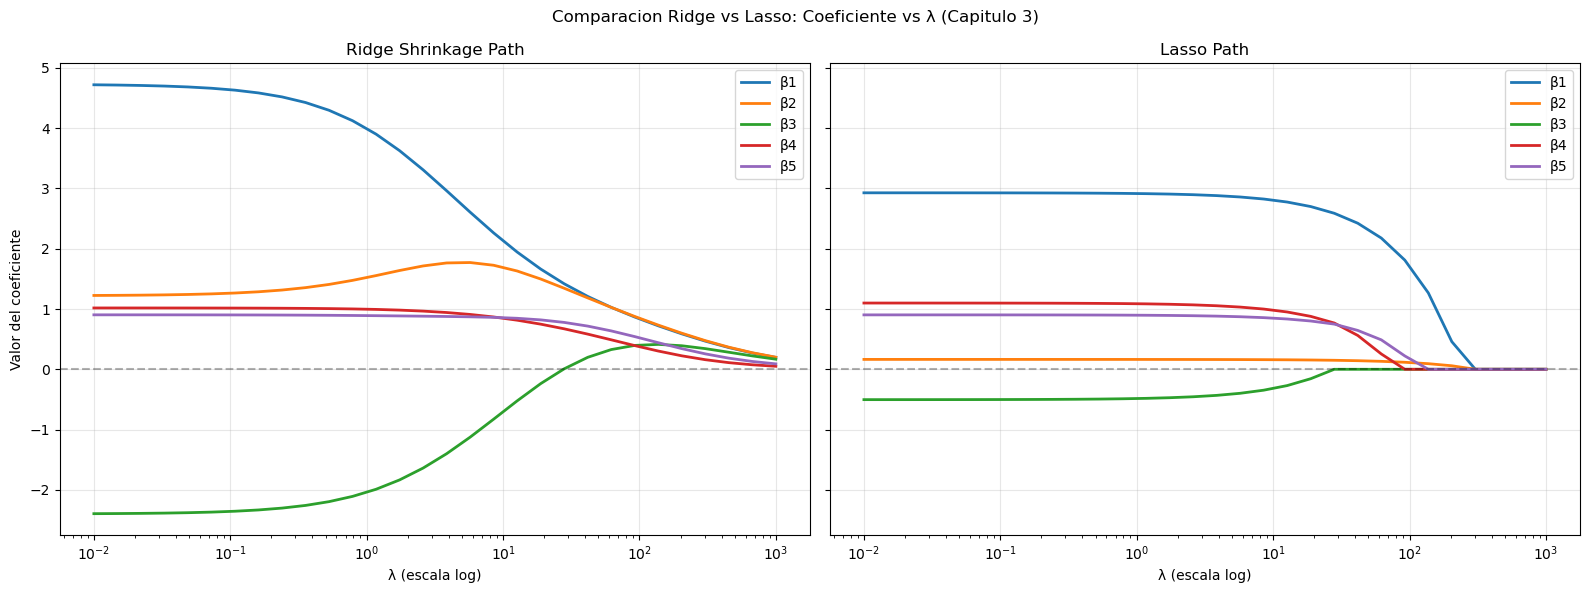

In [21]:
lambdas = np.logspace(-2, 3, 30)

# Ridge path
coef_path_ridge = np.zeros((len(lambdas), 5))
for i, lam in enumerate(lambdas):
    betas = ridge_regression(X_design, y, lam)
    coef_path_ridge[i] = betas[1:]

# Lasso path
coef_path_lasso = np.zeros((len(lambdas), 5))
for i, lam in enumerate(lambdas):
    betas = lasso_coordinate_descent(X_design, y, lam)
    coef_path_lasso[i] = betas[1:]

# Grafico comparativo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Ridge
for j in range(5):
    ax1.plot(lambdas, coef_path_ridge[:, j], label=f'β{j+1}', linewidth=2)
ax1.set_xscale('log')
ax1.set_xlabel('λ (escala log)')
ax1.set_ylabel('Valor del coeficiente')
ax1.set_title('Ridge Shrinkage Path')
ax1.axhline(0, color='k', linestyle='--', alpha=0.3)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Lasso
for j in range(5):
    ax2.plot(lambdas, coef_path_lasso[:, j], label=f'β{j+1}', linewidth=2)
ax2.set_xscale('log')
ax2.set_xlabel('λ (escala log)')
ax2.set_title('Lasso Path')
ax2.axhline(0, color='k', linestyle='--', alpha=0.3)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Comparacion Ridge vs Lasso: Coeficiente vs λ (Capitulo 3)')
plt.tight_layout()
plt.show()

In [22]:
lambdas_comparacion = [0.0, 0.1, 1.0, 10.0, 100.0]

print("Comparacion de coeficientes para diferencias λ\n")
print("λ\t\tβ1\tβ2\t\tβ3\t\tβ4\t\tβ5")
print("-"*60)

for lam in lambdas_comparacion:
    # Ridge
    betas_ridge = ridge_regression(X_design, y, lam)
    print(f"{lam:.1f} (Ridge)\t", end="")
    print("\t".join(f"{b:.3f}" for b in betas_ridge[1:]))

    # Lasso
    betas_lasso = lasso_coordinate_descent(X_design, y, lam)
    print(f"{lam:.1f} (Lasso)\t", end="")
    print("\t".join(f"{b:.3f}" for b in betas_lasso[1:]))
    print()

Comparacion de coeficientes para diferencias λ

λ		β1	β2		β3		β4		β5
------------------------------------------------------------
0.0 (Ridge)	4.730	1.221	-2.400	1.018	0.904
Convergencia en iternacion 1
0.0 (Lasso)	2.928	0.164	-0.504	1.099	0.903

0.1 (Ridge)	4.638	1.262	-2.358	1.016	0.902
Convergencia en iternacion 1
0.1 (Lasso)	2.927	0.164	-0.502	1.098	0.902

1.0 (Ridge)	3.997	1.522	-2.042	0.997	0.891
Convergencia en iternacion 1
1.0 (Lasso)	2.916	0.164	-0.485	1.088	0.898

10.0 (Ridge)	2.132	1.693	-0.705	0.848	0.857
Convergencia en iternacion 1
10.0 (Lasso)	2.807	0.159	-0.320	0.982	0.849

100.0 (Ridge)	0.837	0.847	0.403	0.375	0.522
Convergencia en iternacion 1
100.0 (Lasso)	1.719	0.112	0.000	0.000	0.143



## Conclusiones del ejercicio

- *Ridge (L2)*: Reduce la varianza y estabiliza coeficientes en presencia de multicolinealidad, pero mantiene todas las variables (shrinkage suave nunca llaga exatamente a 0).
- *Lasso (L1): Reduce varianza, estabiliza y realiza **selección automática* de variables (coeficientes exactamente 0 → elimina predictores redunndantes o irrelevantes).
-  **Comparacion visual**:

  - En el shrinkage path de ridge: todas las lineas bajan gradualmente hacia 0, pero nunca lo tocan.
  -  En el lasso path: algunas lineas se "apagan" completamente (se quedan planas en 0 para λ mayores → selecion de caracteristicas.)
-  **Cuándo usar cada uno**:

  - Ridge: cuando todas las variables son potencialmente útiles y hay multicolinealidad fuerte (estabiliza sin descartar).
  - Lasso: cuando queremos un modelo mas interpretable/simple, o cuando sospechamos que muchas variables son irrelevantes (seleccion automatica).

Este ejercicio demuestra la diferencia clave entre penalizacion L2 y L1, tal como explica el Capitulo 3 de ESL

